### Clustering sui giocatori

In [19]:
#import
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import KMeans

warnings.filterwarnings('ignore')

#PATH dove andare a leggere e a scrivere
PATH_TO_WRITE_ETL = "./dataset_modificato_WC/"
PATH_FROM_READ_ETL = "./dataset_originale_WC/"
PATH_FROM_READ_ANALYSIS = "./dataset_modificato_WC/" 

<IPython.core.display.Javascript object>


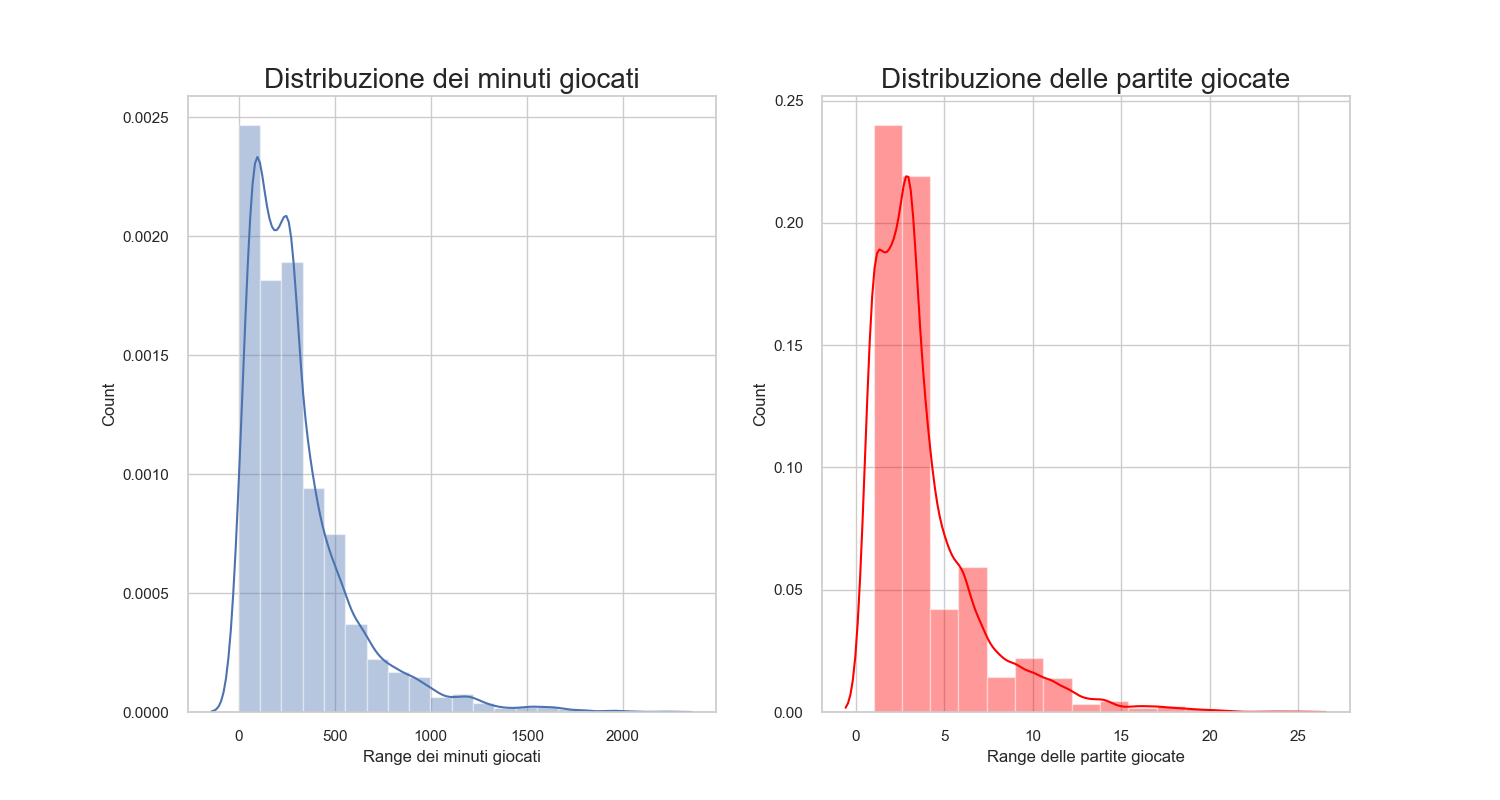

In [20]:
#eliminazione e filtraggio colonne
df_player_stats = pd.read_csv("./stats/stats_players.csv")

df_player_stats = df_player_stats[df_player_stats['n_minutes_played']>0]
df_player_stats['red_card'] = df_player_stats['second_yellow_card'] + df_player_stats['red_card']
df_player_stats = df_player_stats.drop(columns=['second_yellow_card'])
df_player_stats = df_player_stats.drop(columns=['total_own_goals'])
df_player_stats = df_player_stats.drop(columns=['yellow_card'])
df_player_stats = df_player_stats.drop(columns=['red_card'])

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(df_player_stats['n_minutes_played'], kde=True, bins=20)
plt.title('Distribuzione dei minuti giocati', fontsize = 20)
plt.xlabel('Range dei minuti giocati')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(df_player_stats['total_games_played'], color = 'red',kde=True, bins=15)
plt.title('Distribuzione delle partite giocate', fontsize = 20)
plt.xlabel('Range delle partite giocate')
plt.ylabel('Count')
plt.show()

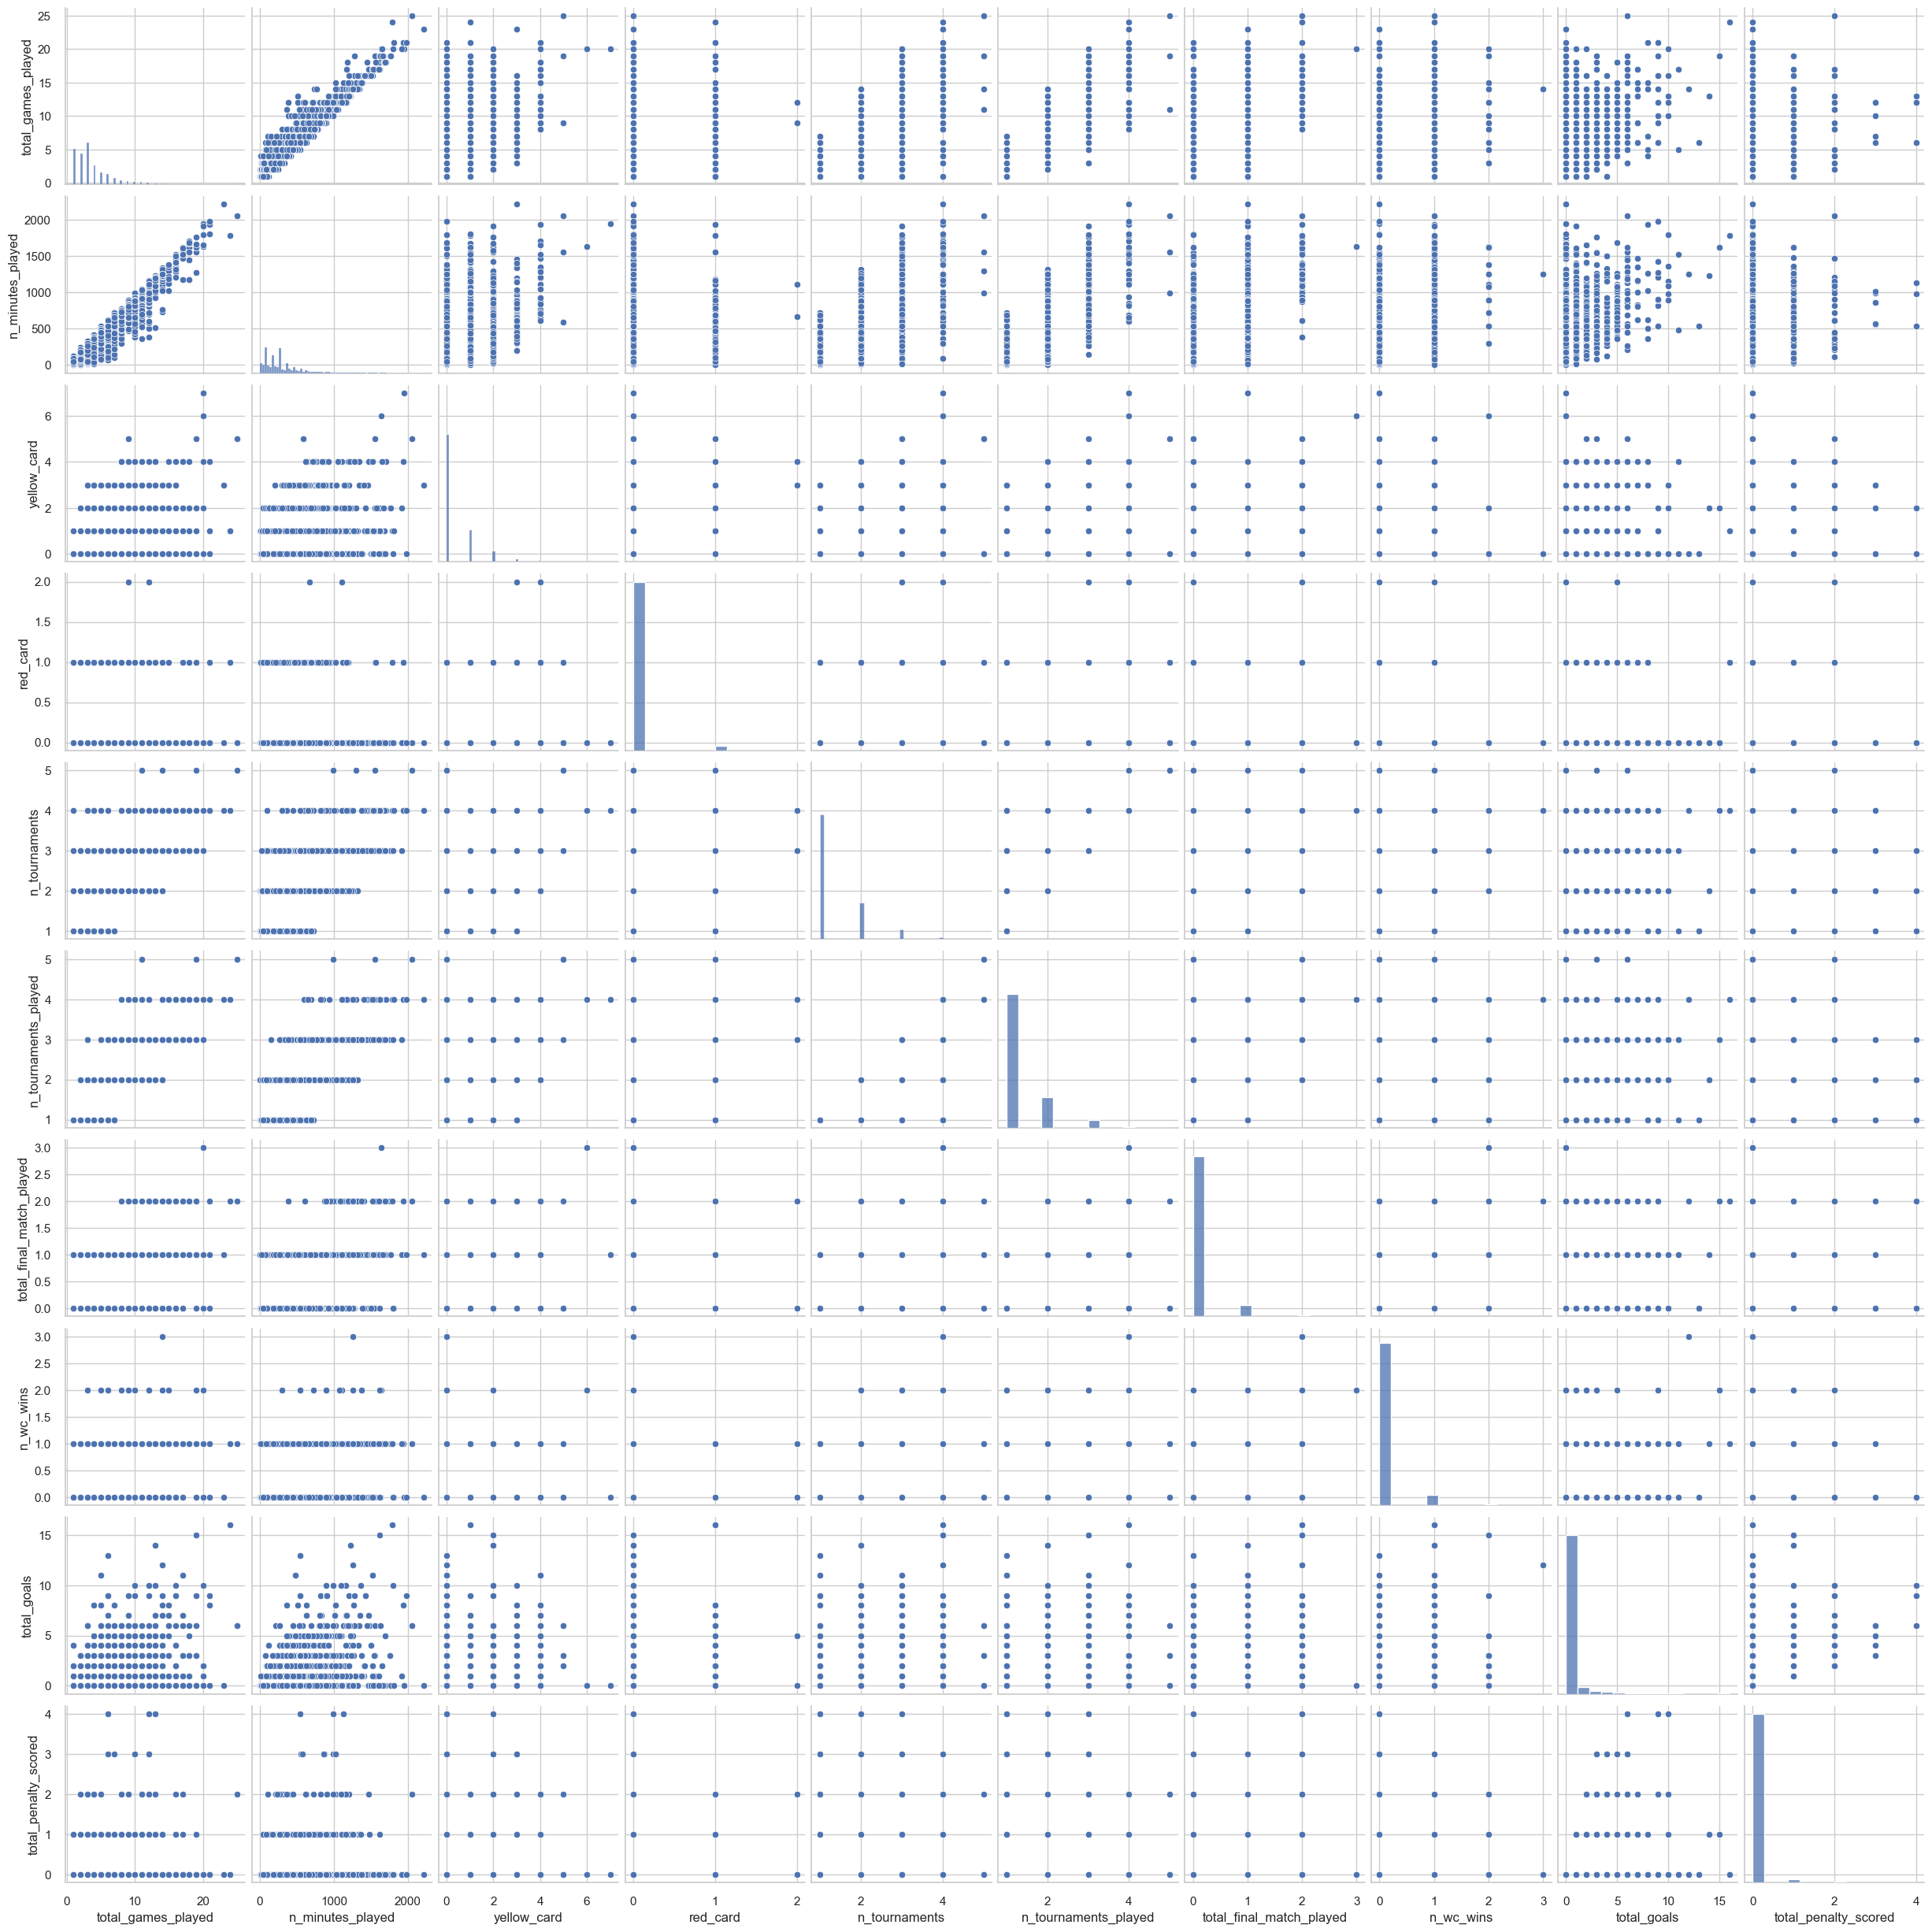

In [251]:
sns.pairplot(df_player_stats.drop(["player_id"], axis=1))

<IPython.core.display.Javascript object>


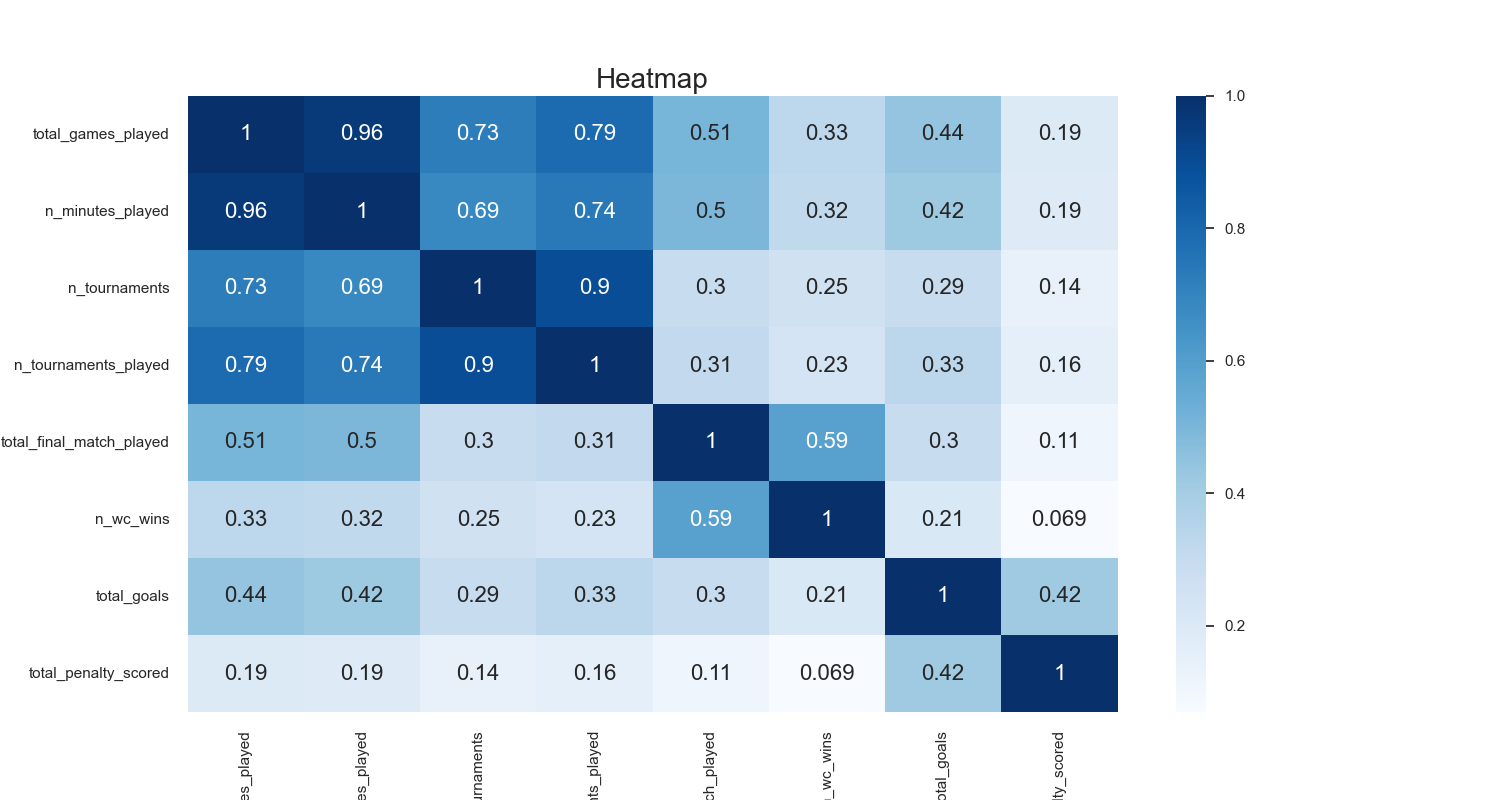

In [21]:
plt.figure(figsize=(15,8))
sns.heatmap(df_player_stats.drop(["player_id"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

5.371399481506098e-17 1.0
(6085, 8)


<IPython.core.display.Javascript object>


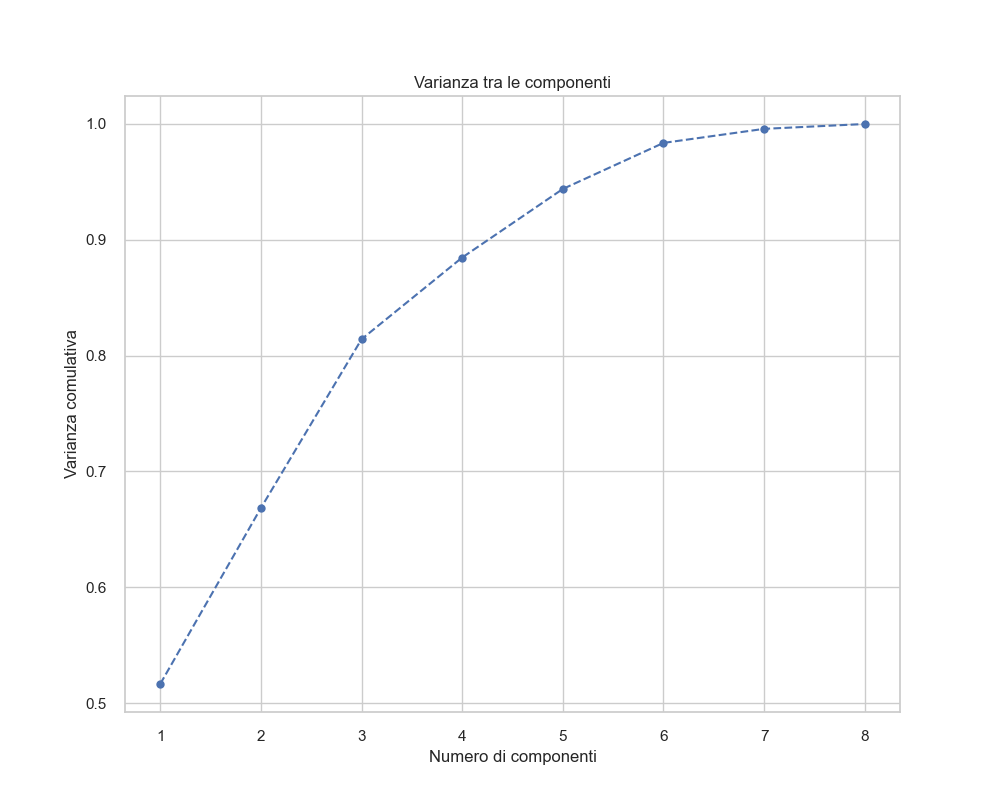

In [22]:
df_player_stats_std = KMeans.normalize_df(df_player_stats.drop(columns=["player_id"]))
KMeans.plot_variance_ratio(df_player_stats_std)

#should select value with 80% information

<IPython.core.display.Javascript object>


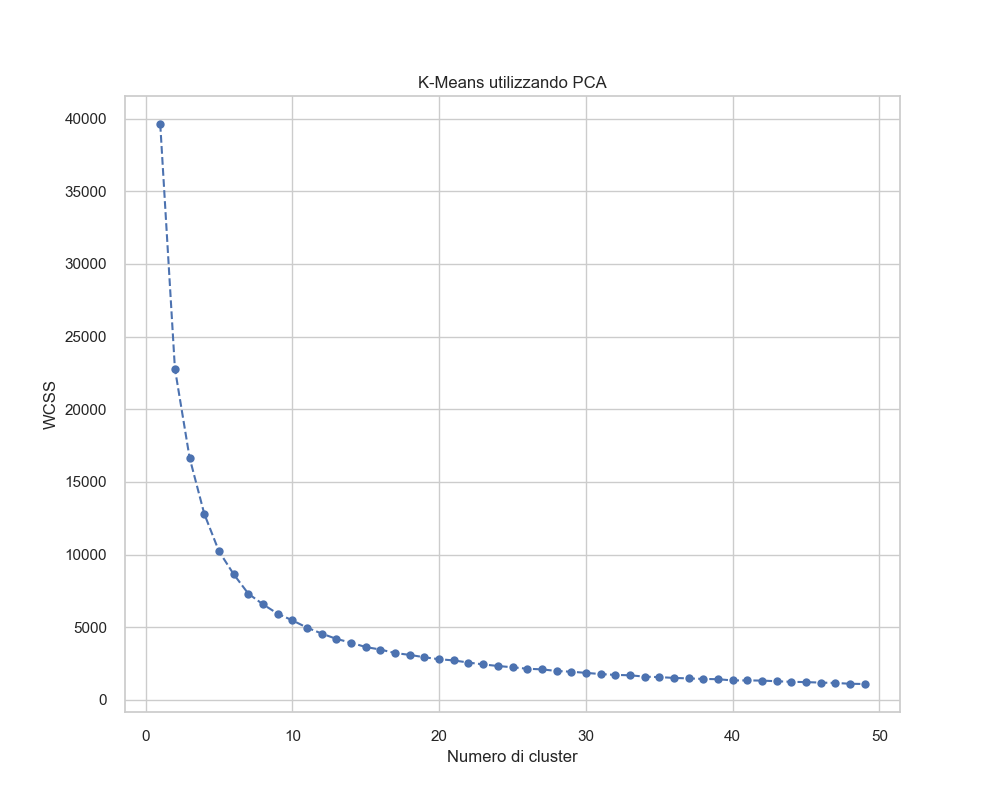

Numero di cluster (k-means): 7


In [23]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_player_stats_std,3)
wcss = KMeans.get_wcss(scores_pca)
kmeans_pca = KMeans.plot_wcss_and_apply_kMeans(wcss,scores_pca)

<IPython.core.display.Javascript object>


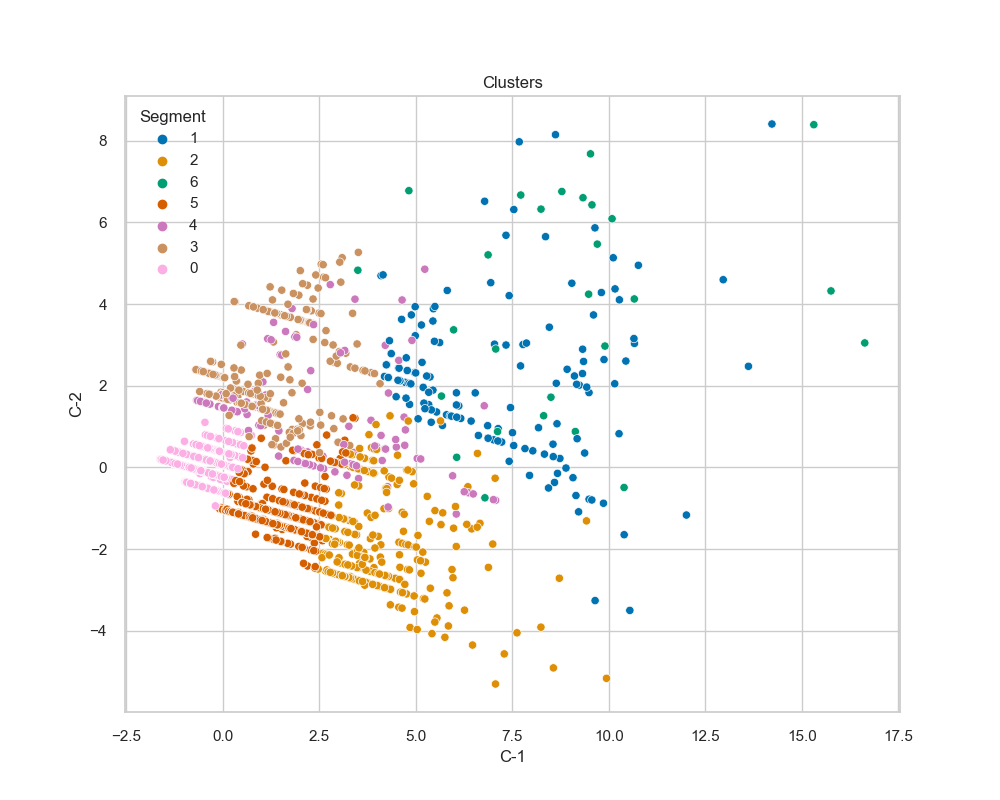

,player_id,total_games_played,n_minutes_played,n_tournaments,n_tournaments_played,total_final_match_played,n_wc_wins,total_goals,total_penalty_scored,C-1,C-2,C-3,Segm K-means PCA,Segment
0,P-06163,20,1950,4,4,1,0,0,0,9.647707,-3.261832,-1.808256,1,1
1,P-08404,20,1639,4,4,3,2,0,0,12.964881,4.597754,-6.639769,1,1
2,P-02847,19,1554,5,5,0,0,3,0,9.942868,-5.165920,0.431409,2,2
3,P-02970,9,587,3,3,0,0,2,0,3.817236,-2.240679,0.471530,2,2
4,P-01993,25,2054,5,5,2,1,6,2,16.630496,3.049203,4.618529,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6080,P-04911,1,46,1,1,0,0,0,0,-1.538366,0.180107,-0.004568,0,0
6081,P-04912,9,810,2,2,0,0,2,0,2.806678,-1.170125,0.549759,5,5
6082,P-01489,2,180,1,1,0,0,0,0,-1.164022,0.080895,-0.035129,0,0
6083,P-04915,3,270,1,1,0,0,1,0,-0.622296,0.239328,0.373048,0,0


In [24]:
df_segm_pca_kmeans = KMeans.concat_df(df_player_stats,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

0.66


<IPython.core.display.Javascript object>


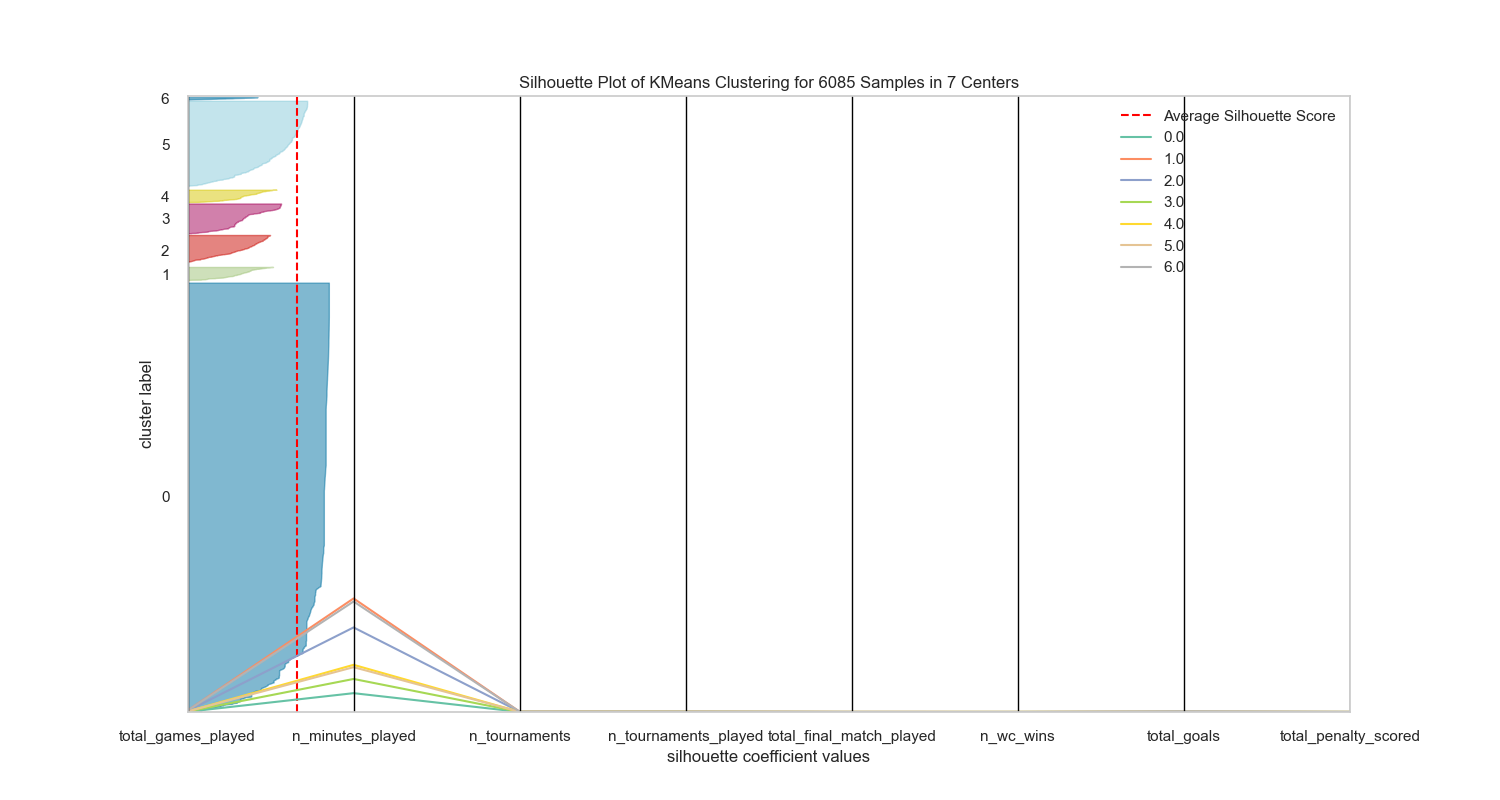

In [25]:
KMeans.evaluation(scores_pca,kmeans_pca)


In [26]:
df_players = pd.read_csv(PATH_FROM_READ_ANALYSIS+"players.csv")
df_segm_pca_kmeans_2 = df_players[["player_id","family_name","given_name"]].merge(df_segm_pca_kmeans,how="right",on="player_id")
path_save = "clusters/clusters_players/"
KMeans.save_clusters_in_csv_files(df_segm_pca_kmeans_2,scores_pca,path_save)
centroids = KMeans.calculate_centroids(df_segm_pca_kmeans_2,scores_pca,path_save,3)
#show centroids
parallel_coordinates(centroids,'group',colormap=plt.get_cmap("Set2"))

plt.show()

-5.1989921488976546e-17 0.7071067811865476
(4288, 8)
1.586032892321652e-17 1.0
(147, 8)
4.4408920985006264e-17 1.0
(310, 8)
-5.933323049636083e-17 1.0
(305, 8)
9.432558900623889e-18 1.0
(128, 8)
9.462128050782583e-18 0.9354143466934853
(880, 8)
1.644774851296528e-17 1.0
(27, 8)


<IPython.core.display.Javascript object>


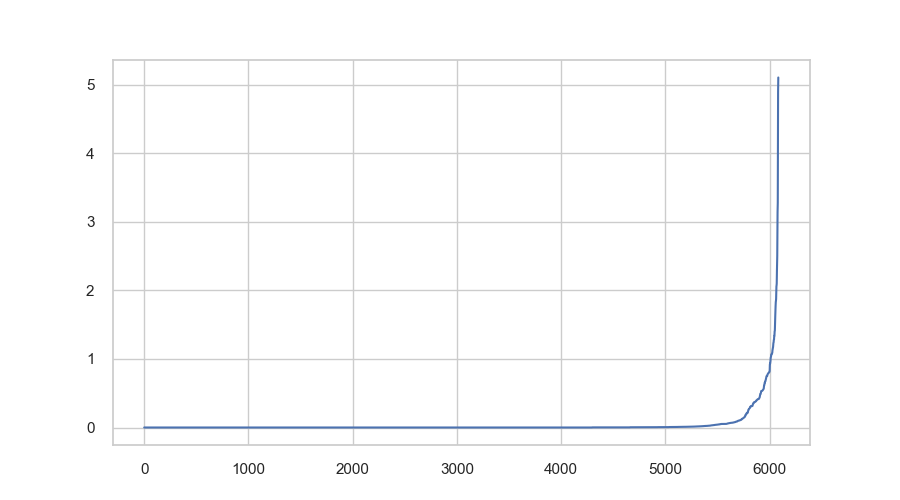

(6085, 3)


In [27]:
#DB-SCAN

from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scores_pca)
distances, indices = nbrs.kneighbors(scores_pca)

distances = np.sort(distances, axis=0)
plt.figure(figsize=(9,5))
plt.plot(distances[:,1])
print(scores_pca.shape)

In [1]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.5, min_samples=5).fit(scores_pca)
ymeans = db.labels_
print(set(ymeans))

df_segm_pca_dbScan= pd.concat([df_player_stats.reset_index(drop=True),pd.DataFrame(ymeans)],axis=1)
df_segm_pca_dbScan_2 = df_players[["player_id","family_name","given_name"]].merge(df_segm_pca_dbScan,how="right",on="player_id")
df2 = pd.DataFrame()
for i in range(-1,len(set(ymeans))-1):
    df = df_segm_pca_dbScan_2[df_segm_pca_dbScan_2[0]==i]
    df.sort_values(by="n_minutes_played",ascending=False).to_csv("clusters/cluster_players_dbscan/cluster_"+str(i)+".csv",index=False)
    df = df[["total_games_played","n_minutes_played","n_tournaments","n_tournaments_played","total_final_match_played","n_wc_wins","total_goals","total_penalty_scored"]]
    #,"yellow_card","red_card","total_own_goals"
    average = df.mean()
    total = df.count()
    average.name = 'mean'
    total.name = 'total'
    df2 = df2.append(average)
    df2 = df2.append(total)
dbscan_silhuouette = silhouette_score(scores_pca,db.labels_).round(2)
print(dbscan_silhuouette)
df2

#db = DBSCAN(eps=1.8, min_samples=5)
#visualizer = SilhouetteVisualizer(db, colors='yellowbrick',estimator=db)

#plt.figure(figsize=(15,8))
#visualizer.fit(scores_pca)        # Fit the data to the visualizer
#visualizer.show()  
df_segm_pca_dbScan   


NameError: name 'scores_pca' is not defined

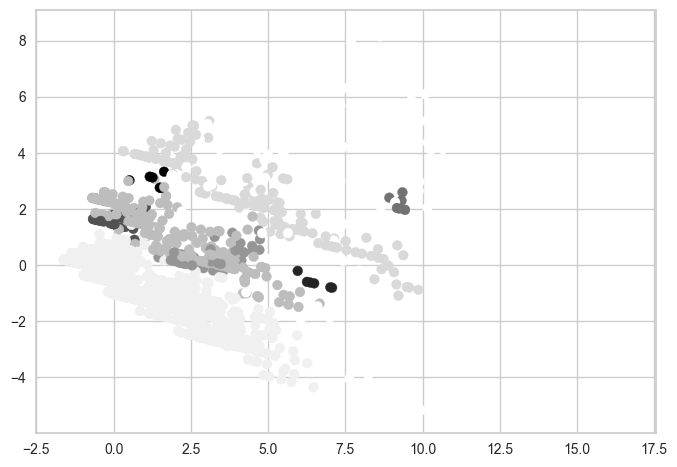

In [21]:
x_axis=df_segm_pca_kmeans['C-1']
y_axis=df_segm_pca_kmeans['C-2']
colors = db.labels_
plt.scatter(x_axis, y_axis, c = colors)

In [29]:
#Metodo per trovare eps
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 8).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
    if(number_of_clusters > 2):
        silhouette_s = silhouette_score(scores_pca,dbscan_model_.labels_).round(2)    
    else: 
        silhouette_s =1
    return(noise_mean_distance, number_of_clusters, silhouette_s)

In [30]:
eps_to_test = [round(eps,1) for eps in np.arange(0.8, 1.5, 0.1)]
min_samples_to_test = range(5, 25, 5)

print("EPS:", eps_to_test)
print("MIN_SAMPLES:", list(min_samples_to_test))
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

results_silhouette = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric,silhouette_metric = get_metrics(eps, min_samples, scores_pca, iter_)
    
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric
        results_silhouette.loc[eps, min_samples] = silhouette_metric

EPS: [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
MIN_SAMPLES: [5, 10, 15, 20]
ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.8 and min_samples =   5 | 2.199    8
  2 | Tested with eps = 0.8 and min_samples =  10 | 1.677    5
  3 | Tested with eps = 0.8 and min_samples =  15 | 1.556    6
  4 | Tested with eps = 0.8 and min_samples =  20 | 1.386    6
  5 | Tested with eps = 0.9 and min_samples =   5 | 2.217    8
  6 | Tested with eps = 0.9 and min_samples =  10 | 1.845    7
  7 | Tested with eps = 0.9 and min_samples =  15 | 1.589    5
  8 | Tested with eps = 0.9 and min_samples =  20 | 1.473    6
  9 | Tested with eps = 1.0 and min_samples =   5 | 2.273    8
 10 | Tested with eps = 1.0 and min_samples =  10 | 1.935    5
 11 | Tested with eps = 1.0 and min_samples =  15 | 1.688    5
 12 | Tested with eps = 1.0 and min_samples =  20 | 1.575    5
 13 | Tested with eps = 1.1 and min_sample

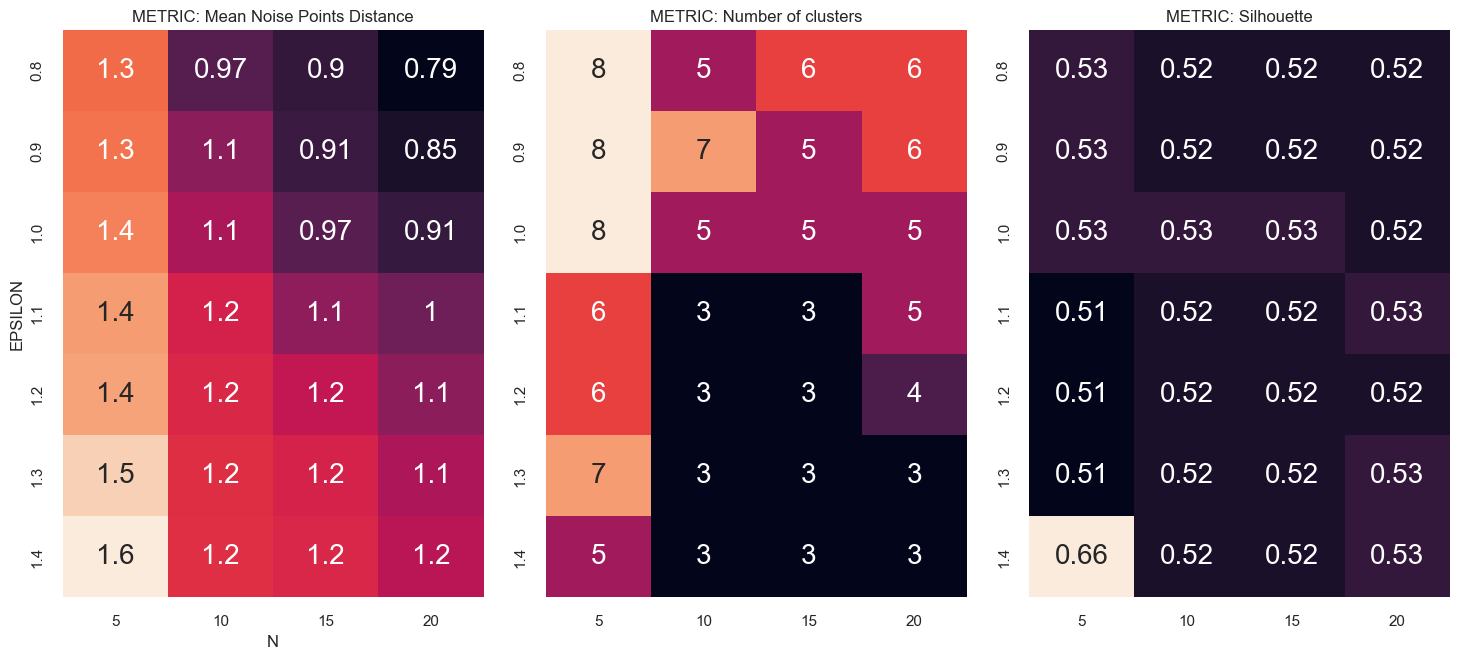

In [28]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,7) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")
sns.heatmap(results_silhouette, annot = True, ax = ax3, cbar = False).set_title("METRIC: Silhouette")

ax1.set_xlabel("N"); ax1.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax1.set_ylabel("EPSILON")


plt.tight_layout(); plt.show()

6085
6085


<IPython.core.display.Javascript object>


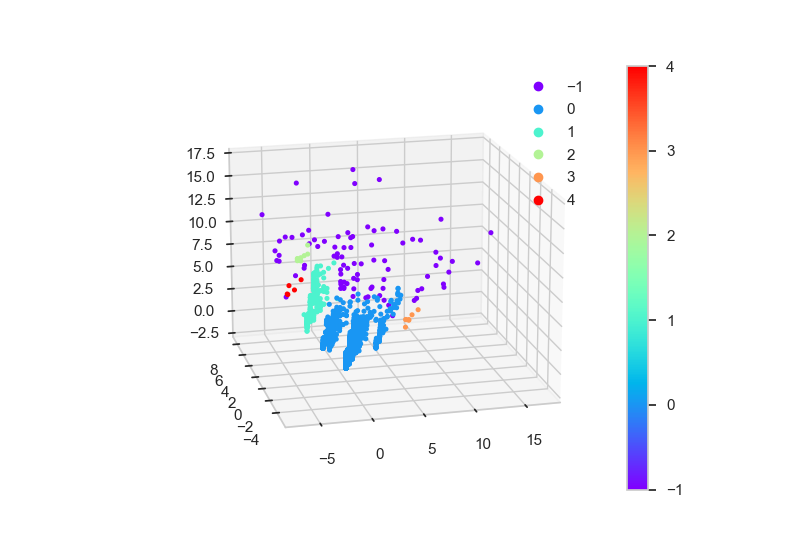

In [29]:
#df_segm_pca_dbScan = pd.concat([df_segm_pca_dbScan,pd.DataFrame(scores_pca)])
print(len(df_segm_pca_dbScan))
print(len(scores_pca))
df_segm_pca_dbScan = KMeans.concat_df(df_segm_pca_dbScan,scores_pca,db)
z_axis = df_segm_pca_dbScan['C-1']
x_axis=df_segm_pca_dbScan['C-3']
y_axis=df_segm_pca_dbScan['C-2']
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
c = np.tile(df_segm_pca_dbScan['Segm K-means PCA'],1)
sc = ax.scatter(x_axis, y_axis, z_axis, alpha=1, c=c, cmap='rainbow', s=7)
plt.legend(*sc.legend_elements())
plt.colorbar(sc)
plt.show()